## Tensorflow Tutorial

### 1. Exploring the libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

In [3]:
y_hat = tf.constant(36, name="y_hat")
y = tf.constant(39, name="y")

loss = tf.Variable((y-y_hat)**2, name="loss")
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print(sess.run(loss))

9


In [4]:
a = tf.constant(2)
b = tf.constant(10)
c = tf.multiply(a,b)
print(c)

Tensor("Mul:0", shape=(), dtype=int32)


In [5]:
sess = tf.Session()
print(sess.run(c))

20


In [6]:
x = tf.placeholder(tf.float32, name="x")
print(sess.run(2*x, feed_dict={x:5}))

10.0


### 2. Building first neura; network

In [7]:
#load the dataset 
X_train_org, Y_train_org, X_test_org, Y_test_org, classes = load_dataset()

y = 5


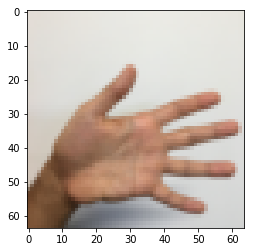

In [8]:
index = 0
plt.imshow(X_train_org[index])
print("y = "+str(np.squeeze(Y_train_org[:,index])))

In [9]:
#flatten the training and testing set
X_train_flatten = X_train_org.reshape(X_train_org.shape[0],-1).T
X_test_flatten = X_test_org.reshape(X_test_org.shape[0],-1).T
#normalize the values
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
#convert training and testing labels into one hot matrices
Y_train = convert_to_one_hot(Y_train_org, 6)
Y_test = convert_to_one_hot(Y_test_org, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


#### 2.1 Create placeholders

In [10]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, shape=[n_x,None], name="X")
    Y = tf.placeholder(tf.float32, shape=[n_y,None], name="Y")
    
    return X,Y

#### 2.2 Initialize the parameters

In [11]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [25,12288], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [25,1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12,1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6,12], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [6,1], initializer=tf.zeros_initializer())
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

#### 2.3 Forward propagation

In [12]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    return Z3

#### 2.4 Compute Cost

In [13]:
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

#### 2.5 Backward propagation and parameters update

#### 2.6 Building the model

In [14]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001, num_epochs=1500,
         mini_batch_size=32, print_cost=True):
    
    (n_x,m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    
    #optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0
            num_minibatches = int(m/mini_batch_size)
            minibatches = random_mini_batches(X_train, Y_train, mini_batch_size)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                _, minibatch_cost = sess.run([optimizer, cost], 
                                             feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                epoch_cost += minibatch_cost/num_minibatches
            
            if print_cost and epoch%100==0:
                print("Cost after epoch {} : {}".format(epoch, epoch_cost))
            if print_cost and epoch%5==0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        print("parameters has been trained")
        
        correct_preditions = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        
        accuracy = tf.reduce_mean(tf.cast(correct_preditions, "float"))
        
        print("Train Accuracy : ", accuracy.eval({X:X_train, Y:Y_train}))
        print("Test Accuracy : ", accuracy.eval({X:X_test, Y:Y_test}))
        
        return parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Cost after epoch 0 : 1.8661420778794722
Cost after epoch 100 : 0.8001617030663924
Cost after epoch 200 : 0.5759899336280243
Cost after epoch 300 : 0.43232766606590967
Cost after epoch 400 : 0.32158493679581274
Cost after epoch 500 : 0.23754453072042178
Cost after epoch 600 : 0.17514062085838025
Cost after epoch 700 : 0.14322399077090356
Cost after epoch 800 : 0.09165669672868468
Cost after epoch 900 : 0.06134847850736343
Cost after epoch 1000 : 0.06389132125133819
Cost after epoch 1100 : 0.03271269786990049
Cost after epoch 1200 : 0.0197746307504448
Cost after epoch 1300 : 0.013255628870066365
Cost after epoch 1400 : 0.4605836899894656


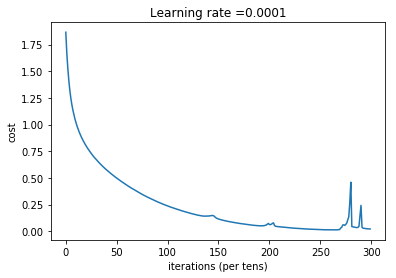

parameters has been trained
Train Accuracy :  0.98888886
Test Accuracy :  0.8333333


In [15]:
#train the model
parameters = model(X_train, Y_train, X_test, Y_test)